In [4]:
from nbodykit.lab import *
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['xtick.labelsize'] = 'large'
plt.rcParams['ytick.labelsize'] = 'large'
plt.rcParams['axes.labelsize'] = 'large'
%config Completer.use_jedi = False
%config InlineBackend.figure_format = 'retina'
from matplotlib.colors import LogNorm
import os, sys
sys.path.insert(0,'../')
from lib.tng_lib import *
from scipy import interpolate
import h5py

zout = 1
zic = 127
BoxSize = 1000.
Nmesh = 256

sim = 1
nsim = 1000

output_folder = '/shares/stadel.ics.mnf.uzh/aobulj/hifi_mocks_Paco_noise/'
sample = np.load('sobol_sequence_om_s8_b1_b2_bG2_Psn.npy')
params = ['$\\Omega_m$', '$\\sigma_8$', '$b_1$', '$b_2$', '$b_{\\mathcal{G}_2}$', '$P_\\mathrm{noise}$']

c_fiducial = cosmology.Cosmology(h=0.6774, T0_cmb=2.725, Omega0_b=0.0486, Omega0_cdm=0.2603, m_ncdm=[], n_s=0.9667, k_pivot=0.05, A_s=2.055e-9, YHe=0.24)

Plinout_fiducial = cosmology.LinearPower(c_fiducial, zout)
klin = np.logspace(-2,0,1000)

In [6]:
sample = np.load('sobol_sequence_om_s8_b1_b2_bG2_Psn.npy')
print (sample.shape)
print (sample[1023])

array([  0.29133289,   0.63083317,   1.68300563,  -0.68397534,
         0.82981062, 236.5476346 ])

In [43]:
sample.min(axis=0), sample.max(axis=0)

(array([ 0.105029,  0.600452,  0.514537, -0.99517 , -0.99968 , 86.879466]),
 array([4.9549200e-01, 9.9876500e-01, 1.9907740e+00, 9.8650300e-01,
        9.9319500e-01, 9.9641804e+02]))

In [4]:
sample.shape

(100, 6)

0


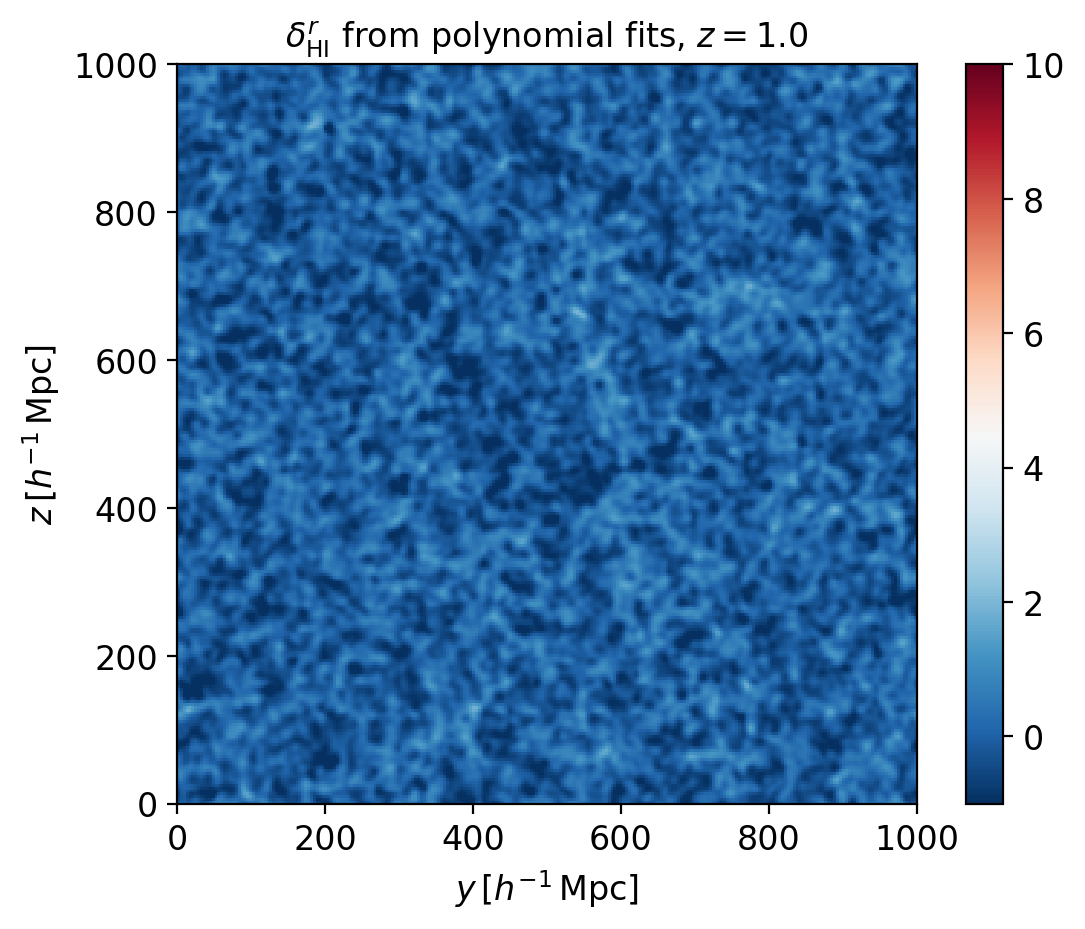

In [5]:
R_gaussian = 5 # Mpc/h
imshow_kw = dict(interpolation='none', cmap='RdBu_r', vmin=-1, vmax=10, extent=(0,BoxSize,0,BoxSize), origin='lower')

for i in range(sim):
    print (i)
    fname = output_folder + "HI_field_poly_L_%.1f_Nmesh_%.1f_zout_1.0_seed_%i.hdf5"%(BoxSize,Nmesh,i)
    f = h5py.File(fname, 'r')
    load_one = f['delta_HI'][:]
    f.close()
    cax = plt.imshow(ArrayMesh(load_one, BoxSize).apply(Gaussian(R_gaussian)).paint()[0,:,:].T, **imshow_kw)
    plt.colorbar(cax)
    plt.title('$\\delta_\\mathrm{HI}^r$ from polynomial fits, $z=%.1f$'%zout)
    plt.xlabel("$y\,[h^{-1}\,\\mathrm{Mpc}]$")
    plt.ylabel("$z\,[h^{-1}\,\\mathrm{Mpc}]$")
    plt.show()

In [6]:
load_one.shape

(256, 256, 256)

In [7]:
nslice = 8

dx = BoxSize/Nmesh

npix_slice = int(Nmesh/nslice)

print ("pixel width [Mpc/h] ", dx)
print ("slice width [Mpc/h] ", dx*Nmesh/nslice)
print ("pixels in slice ", Nmesh/nslice, npix_slice)

pixel width [Mpc/h]  3.90625
slice width [Mpc/h]  125.0
pixels in slice  32.0 32


In [8]:
# nsim = 00
nslice = 8
naxis = 3

maps = np.zeros((nsim, nslice, naxis, Nmesh, Nmesh))
maps.shape

(100, 8, 3, 256, 256)

In [9]:
plot = False

for i in range(nsim):
    # print ('doing %i of %i'%(i,nsim))
    
    fname = output_folder + "HI_field_poly_L_%.1f_Nmesh_%.1f_zout_1.0_seed_%i.hdf5"%(BoxSize,Nmesh,i)
    f = h5py.File(fname, 'r')
    load_one = f['delta_HI'][:]
    f.close()
    
    if plot:
        plt.figure(figsize=[20,4])
        plt.subplot(121)
        cax = plt.imshow(ArrayMesh(load_one, BoxSize).apply(Gaussian(R_gaussian)).paint()[0,:,:].T, **imshow_kw)
        plt.colorbar(cax)
        plt.title('$\\delta_\\mathrm{HI}^r$ from polynomial fits, $z=%.1f$'%zout)
        plt.xlabel("$y\,[h^{-1}\,\\mathrm{Mpc}]$")
        plt.ylabel("$z\,[h^{-1}\,\\mathrm{Mpc}]$")

        pk = FFTPower(ArrayMesh(load_one, BoxSize), mode='1d')
        c = cosmology.Cosmology(h=0.6774, T0_cmb=2.725, Omega0_b=0.0486, Omega0_cdm=sample[i][0]-0.0486, m_ncdm=[], n_s=0.9667, k_pivot=0.05, A_s=2.055e-9, YHe=0.24)
        c = c.match(sigma8=sample[i][1])
        Plinout = cosmology.LinearPower(c, zout)
        plt.subplot(122)
        plt.loglog(pk.power['k'], pk.power['power'].real)
        plt.loglog(pk.power['k'], Plinout(pk.power['k'])*sample[i][2]**2, 'k')
        plt.show()
    
    for j in range(nslice):
        for k in range(naxis):
            if k==0:
                maps[i,j,k,...] = load_one[j*npix_slice:(j+1)*npix_slice,...].mean(axis=k)
            elif k==1:
                maps[i,j,k,...] = load_one[:,j*npix_slice:(j+1)*npix_slice,:].mean(axis=k)
            elif k==2:
                maps[i,j,k,...] = load_one[...,j*npix_slice:(j+1)*npix_slice].mean(axis=k)

In [10]:
maps = maps.reshape(nsim*nslice*naxis, Nmesh, Nmesh)

In [11]:
maps.shape

(2400, 256, 256)

In [12]:
np.save(output_folder + 'maps_%i'%nsim, maps)

In [15]:
maps_load = np.load(output_folder + 'maps_%i.npy'%nsim)

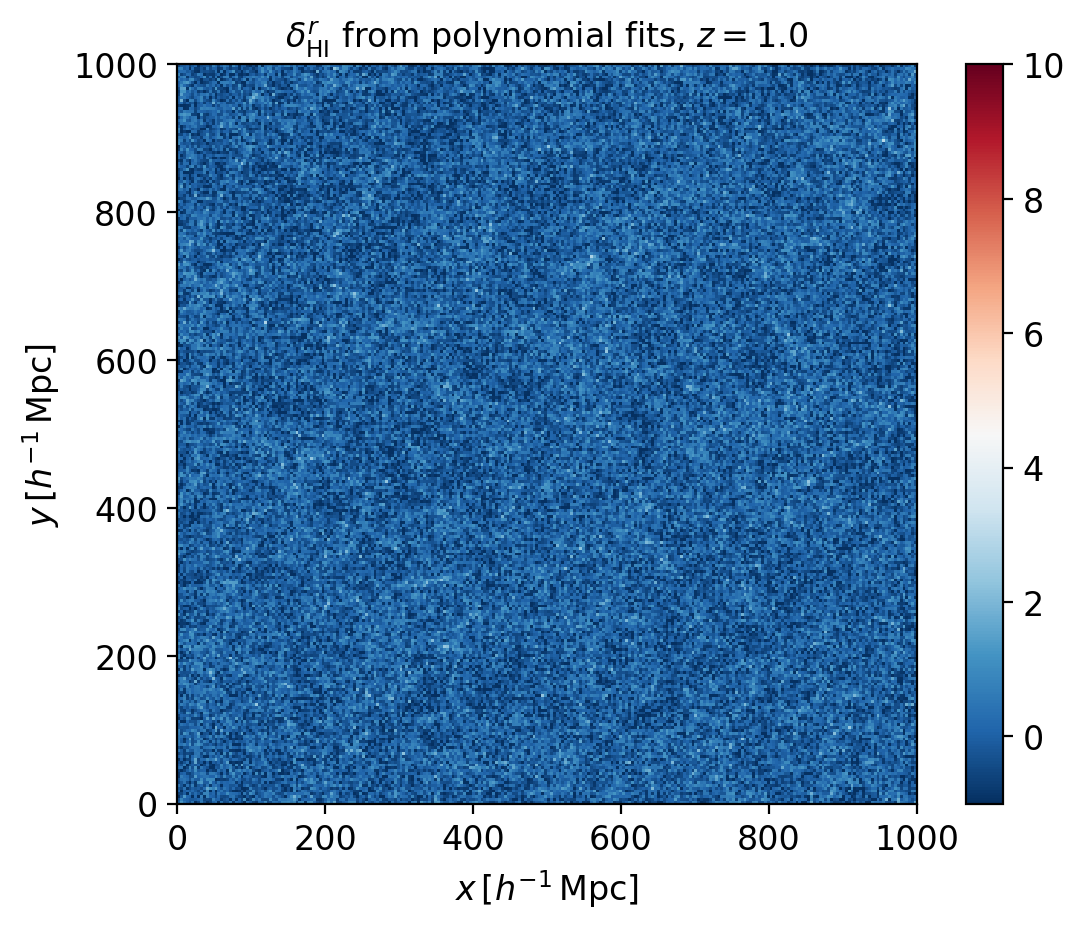

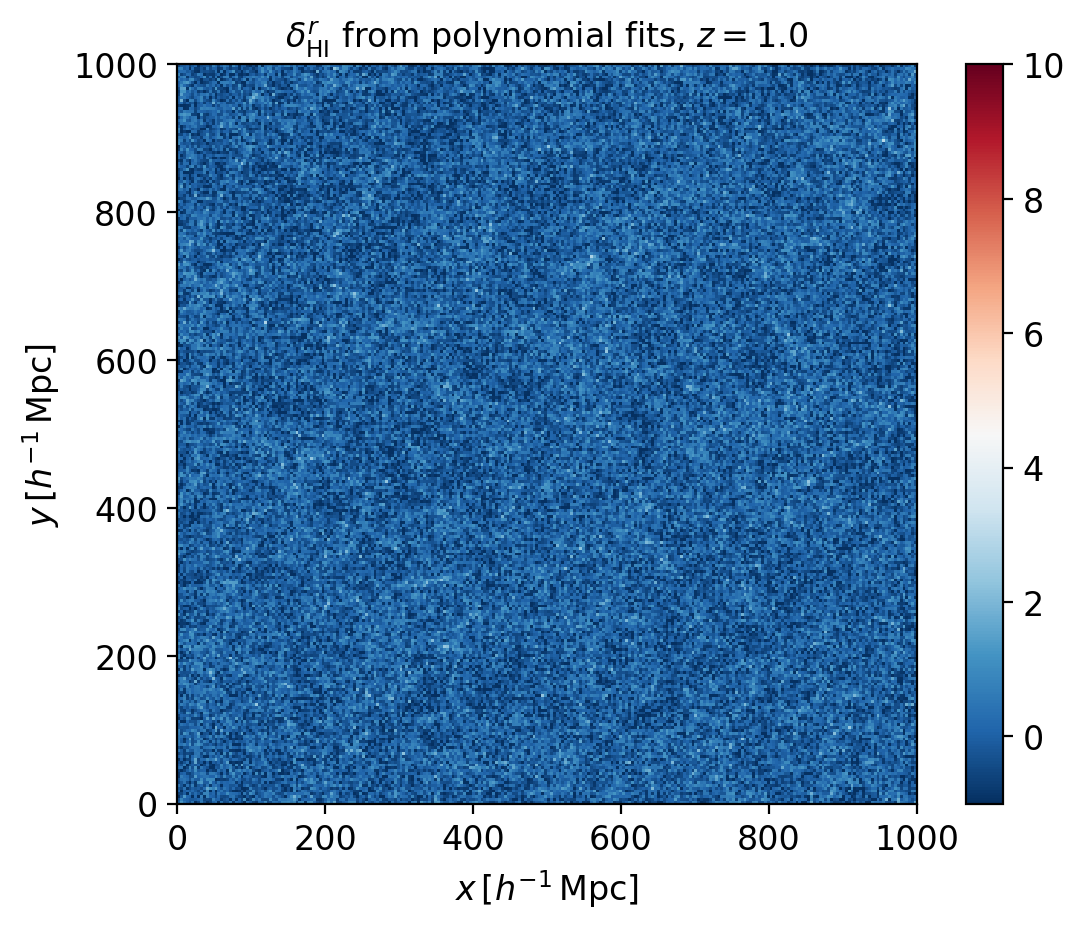

In [16]:
cax = plt.imshow(maps[5].T, **imshow_kw)
plt.colorbar(cax)
plt.title('$\\delta_\\mathrm{HI}^r$ from polynomial fits, $z=%.1f$'%zout)
plt.xlabel("$x\,[h^{-1}\,\\mathrm{Mpc}]$")
plt.ylabel("$y\,[h^{-1}\,\\mathrm{Mpc}]$")
plt.show()
cax = plt.imshow(maps_load[5].T, **imshow_kw)
plt.colorbar(cax)
plt.title('$\\delta_\\mathrm{HI}^r$ from polynomial fits, $z=%.1f$'%zout)
plt.xlabel("$x\,[h^{-1}\,\\mathrm{Mpc}]$")
plt.ylabel("$y\,[h^{-1}\,\\mathrm{Mpc}]$")
plt.show()

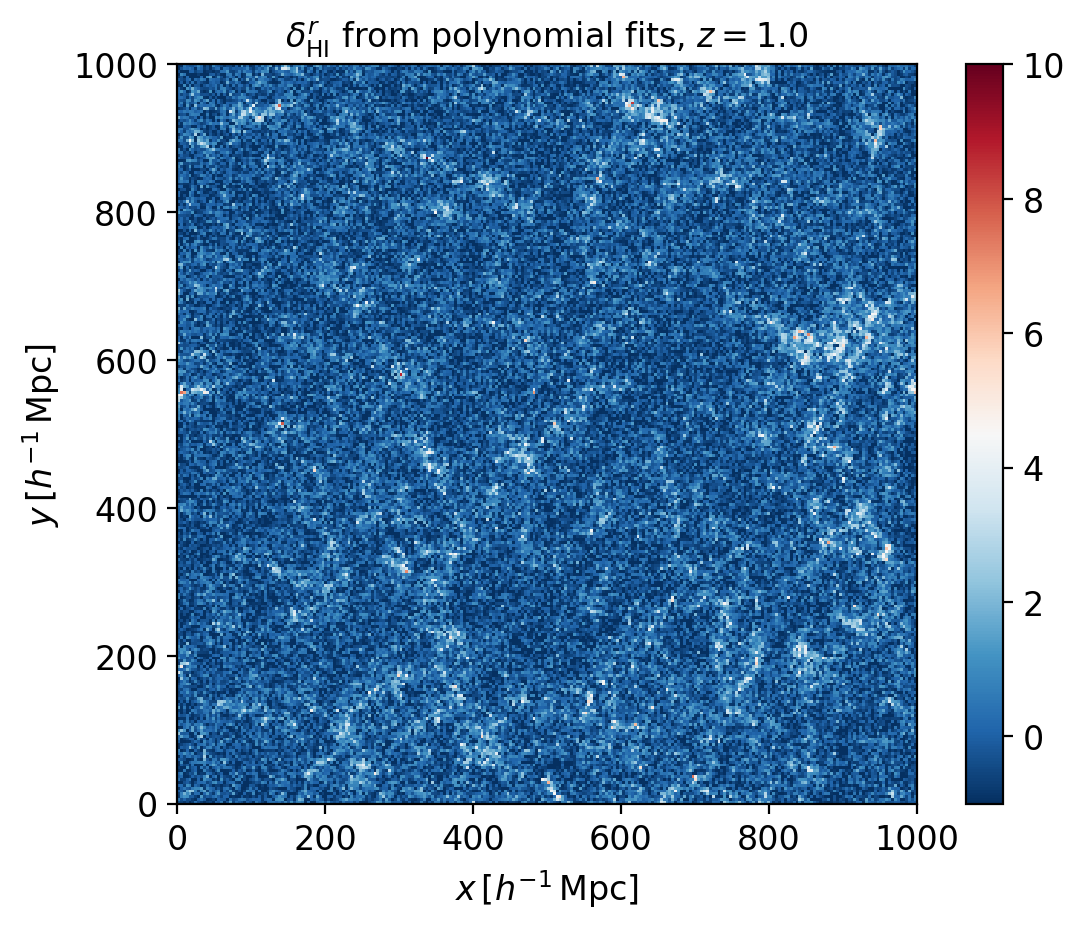

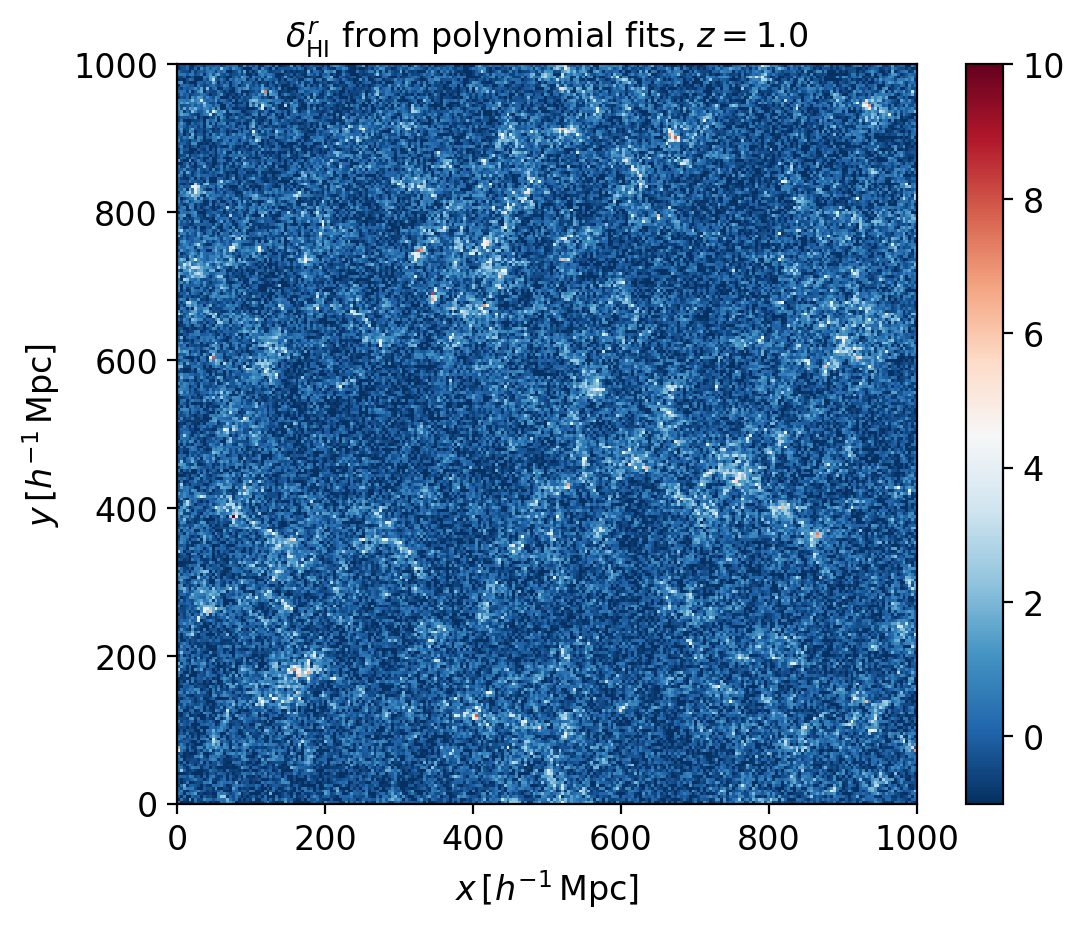

In [17]:
cax = plt.imshow(load_one[-npix_slice:,...].mean(axis=0).T, **imshow_kw)
plt.colorbar(cax)
plt.title('$\\delta_\\mathrm{HI}^r$ from polynomial fits, $z=%.1f$'%zout)
plt.xlabel("$x\,[h^{-1}\,\\mathrm{Mpc}]$")
plt.ylabel("$y\,[h^{-1}\,\\mathrm{Mpc}]$")
plt.show()
cax = plt.imshow(maps[-1].T, **imshow_kw)
plt.colorbar(cax)
plt.title('$\\delta_\\mathrm{HI}^r$ from polynomial fits, $z=%.1f$'%zout)
plt.xlabel("$x\,[h^{-1}\,\\mathrm{Mpc}]$")
plt.ylabel("$y\,[h^{-1}\,\\mathrm{Mpc}]$")
plt.show()

In [2]:
pk = FFTPower(ArrayMesh(load_one, BoxSize), mode='1d')

In [29]:
c = cosmology.Cosmology(h=0.6774, T0_cmb=2.725, Omega0_b=0.0486, Omega0_cdm=sample[i][0]-0.0486, m_ncdm=[], n_s=0.9667, k_pivot=0.05, A_s=2.055e-9, YHe=0.24)
c = c.match(sigma8=sample[i][1])
Plinout = cosmology.LinearPower(c, zout)

833.015268


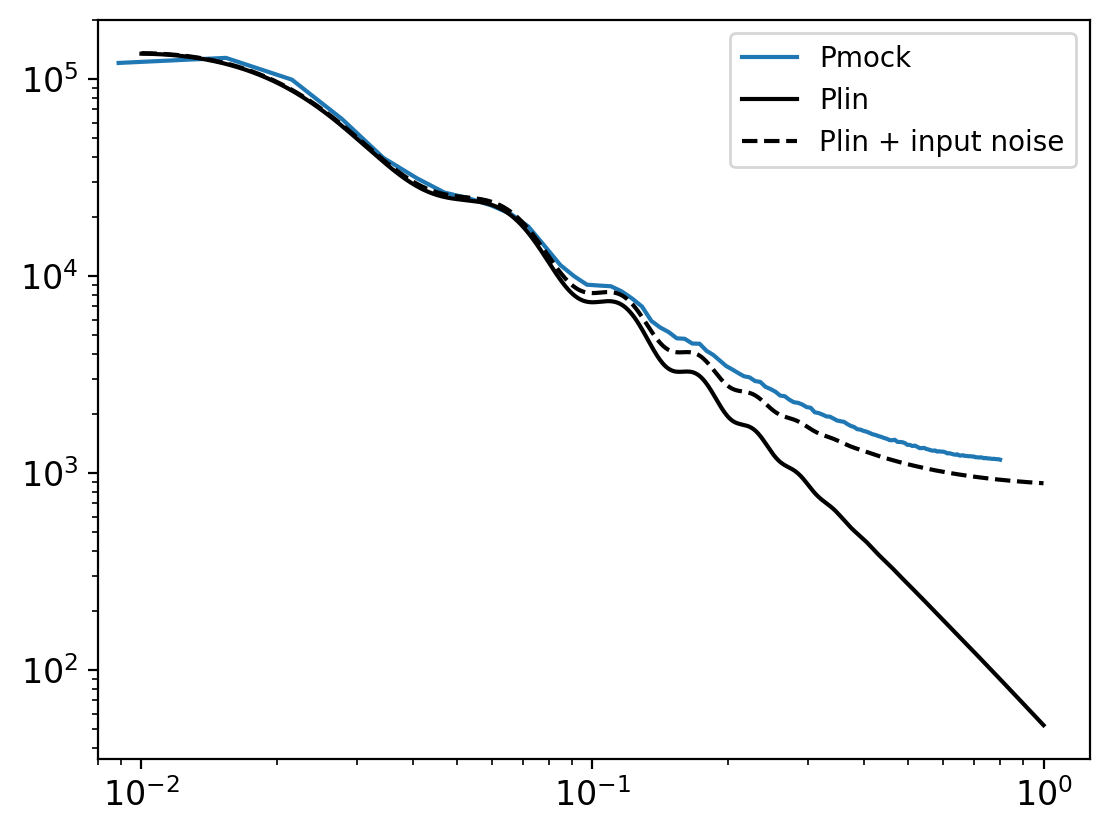

In [40]:
plt.loglog(pk.power['k'][1:], pk.power['power'].real[1:], label = 'Pmock')
plt.loglog(klin, Plinout(klin)*sample[i][2]**2, 'k', label = 'Plin')
plt.loglog(klin, Plinout(klin)*sample[i][2]**2 + sample[i][-1], 'k--', label = 'Plin + input noise')
plt.legend(loc=0)
plt.xlim(8e-3)
print (sample[i][-1])

In [17]:
sample[sim][2]

1.689481